## Problem 1 - Perceptron

### Answer 1.1

Import `numpy` and `matplotlib`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

%matplotlib inline

Define needed functions related to generating and plotting 2D data points

In [2]:
# Function to generate $n$ points of $(x1, x2)$, with range: $low \leq x1 \leq x2 \leq high$
def generate_2D_points(low, high, n_points, seed=None):
    if seed != None:
        np.random.seed(seed)
    
    x1_arr = np.random.uniform(low, high, n_points)
    x2_arr = np.random.uniform(low, high, n_points)

    class_1_data, class_2_data = ([], [])

    for x1, x2 in zip(x1_arr, x2_arr):
        if x1 > x2:
            class_1_data.append((x1, x2))
        else:
            class_2_data.append((x1, x2))

    class_1_data, class_2_data = (np.array(class_1_data), np.array(class_2_data))
    
    return class_1_data, class_2_data

# Function to plot 2D points, color coded based on class (two classes)
def plot_2D_points(class_1_data, class_2_data, class_3_data=[]):
    plt.plot(class_1_data[:, 0], class_1_data[:, 1], 'o', color='green', label='Class 1')

    plt.plot(class_2_data[:, 0], class_2_data[:, 1], 'o', color='blue', label='Class 2')
    
    if len(class_3_data) > 0:
        plt.plot(class_3_data[:, 0], class_3_data[:, 1], 'o', color='red', label='Removed Points')
        
    ax = plt.gca()
    ax.set(xlabel = 'x1', ylabel = 'x2')

    plt.title('2D Scatter Plot for points (x1, x2) in Class 1 (Green) and Class 2 (Blue)')
    plt.legend()
    plt.show()

Generate $20$ points in the `unit square of positive quadrant`, i.e. `Quadrant I` with range: $0 \leq x1 \leq x2 \leq 1$. This is for the training data.

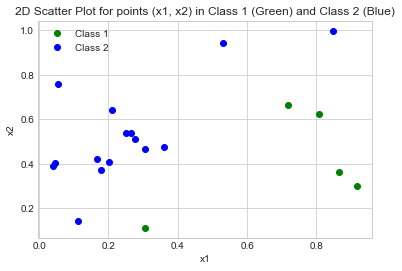

In [3]:
class_1_train_data, class_2_train_data = generate_2D_points(0, 1, 20, 15)

plot_2D_points(class_1_train_data, class_2_train_data)

Generate $1000$ points in the `unit square of positive quadrant`, i.e. `Quadrant I` with range: $0 \leq x1 \leq x2 \leq 1$. This is for the test data.

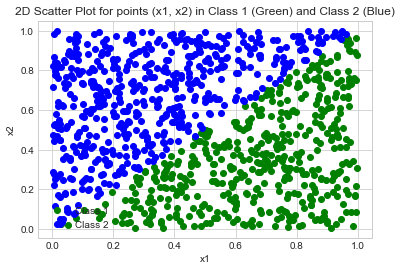

In [4]:
class_1_test_data, class_2_test_data = generate_2D_points(0, 1, 1000, 15)

plot_2D_points(class_1_test_data, class_2_test_data)

Build X and y for train and test, check if the shape matches.


In [5]:
X_train = np.hstack([class_1_train_data.T, class_2_train_data.T])
X_test = np.hstack([class_1_test_data.T, class_2_test_data.T])

assert X_train.shape == (2, 20)
assert X_test.shape == (2, 1000)

y_train = np.concatenate((np.full(len(class_1_train_data), float(1.0)), np.full(len(class_2_train_data), float(-1.0))), axis=None)
y_test = np.concatenate((np.full(len(class_1_test_data), float(1.0)), np.full(len(class_2_test_data), float(-1.0))), axis=None)

assert y_train.shape == (20,)
assert y_test.shape == (1000,)


Shuffle the data first so later in each minibatch, the Perceptron sees data from both labels

In [6]:
def shuffle(X, y):
    idxes = np.arange(X.shape[1])
    np.random.shuffle(idxes)
    
    return np.array([X[0][idxes], X[1][idxes]]), y[idxes]

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

Define Perceptron related functions

In [7]:
# Return label given output using sign function
# x should be an NDARRAY, not a scalar
def sign(x):
    return np.array([1.0 if val >= 0 else -1.0 for val in x])

# Predict label using sign activation
def predict(W, X):
    return sign(np.dot(W.T, X))

# Init weights randomly using normal distribution
def init_weights(w_ranges, seed=None):
    if seed != None:
        np.random.seed(seed)
        
    w1 = np.random.uniform(w_ranges[0][0], w_ranges[0][1], size=None)
    w2 = np.random.uniform(w_ranges[1][0], w_ranges[1][1], size=None)
    
    return np.array([w1, w2])

# X should be in the shape of (n_features, n_data)
# y should be in the shape of (n_data,)
# Function to compute loss
def forward_propagate(W, X, y, algo):
    n_data = X.shape[1]
    
    # a equals 0 for Perceptron Criterion and 1 for Hinge-Loss
    if algo == 'Perceptron criterion':
        a = np.zeros(n_data)
    
    elif algo == 'Hinge loss':
        a = np.full(n_data, 1)
        
    else:
        print('Invalid algorithm')
        assert False
    
    outputs = np.dot(W.T, X)
    assert outputs.shape == (n_data,)
    
    # IMPORTANT: Do ELEMENT-WISE multiplication for y against the output
    diffs = a - np.multiply(y, outputs)
    assert diffs.shape == (n_data,)
    
    losses = np.maximum(np.zeros(n_data), diffs)
    assert losses.shape == (n_data,)
    
    # IMPORTANT: Don't forget to divide the losses 
    # by the total number of data so that the updates
    # are not EXTREME
    losses = np.divide(losses, n_data)
    assert losses.shape == (n_data,)

    return outputs, losses

# X should be in the shape of (n_features, n_data)
# y should be in the shape of (n_data,)
# Function to update weights
def back_propagate(W, X, y, outputs, losses, learning_rate):
    y_preds = sign(outputs)
    assert y_preds.shape == (X.shape[1],)
    
    diff = np.subtract(y, y_preds)
    assert diff.shape == (X.shape[1],)
    
    # Update only when loss > 0
    for i, loss in enumerate(losses):
        if loss > 0.0:
            # IMPORTANT: Slice the second axis
            curr_X = X[:, i]
            assert curr_X.shape == (X.shape[0],)
            
            update_values = np.multiply(learning_rate, np.multiply(curr_X, diff[i]))
            assert update_values.shape == (X.shape[0],)

            W = np.add(W, update_values)
            assert W.shape == (X.shape[0],)
    
    return W

Training related functions

In [8]:
# Train loop, stops when error is zero or when max_iter is reached
def train(X, y, algo, learning_rate, max_iter, w_ranges, seed, debug):
    W = init_weights(w_ranges, seed)
    
    print('Initial Weights:')
    print('w1: {:.2f}, w2: {:.2f}'.format(W[0], W[1]))
    print('-----------------------')

    i = 0
    
    while True:
        outputs, losses = forward_propagate(W, X_train, y_train, algo)
        W = back_propagate(W, X_train, y_train, outputs, losses, learning_rate)
        
        avg_losses = np.mean(losses)
        misc = compute_performance(W, X_train, y_train, 'misc')
        
        if algo == 'Perceptron criterion':
            if misc == 0:
                break
                
        elif algo == 'Hinge loss':
            if avg_losses == 0.0:
                break
                
        else:
            print('Invalid algorithm')
            assert False
        
        i = i + 1
        
        if i < max_iter:
            if debug[0]:
                if i % debug[1] == 0:
                    print('Iteration: {}'.format(i))
                    print('Number of misclassified examples: {}'.format(misc))
                    print('w1: {:.2f}, w2: {:.2f}'.format(W[0], W[1]))
                    print('-----------------------')
        
        else:
            break
    
    print('{} stops at iteration: {}'.format(algo, i))
    print('Number of misclassified examples: {}'.format(misc))
    print('w1: {:.2f}, w2: {:.2f}'.format(W[0], W[1]))
    print('-----------------------')
    
    return W
   
# Call predict to get labels and then compute test accuracy
def compute_performance(W, X, y, ret_type):
    y_preds = predict(W, X)
    
    verdict = [1 if val1 == val2 else 0 for val1, val2 in zip(y_preds, y)]
    
    if ret_type == 'misc':
        return len(y) - np.sum(verdict)
    elif ret_type == 'acc':
        return np.sum(verdict) / len(y)

Train for Perceptron criterion

In [9]:
algo = 'Perceptron criterion'
learning_rate = 0.1
n_iters = 100 # Stop when loss equals zero or reach n_iters
debug = (False, None)

# Initial value range for (w1, w2), uniform random from -0.1 to 0.1
w_ranges = ((-0.1, 0.1), (-0.1, 0.1)) 
seed = 8

W_pc = train(X_train, y_train, algo, learning_rate, n_iters, w_ranges, seed, debug)
test_acc = compute_performance(W_pc, X_test, y_test, 'acc')

print('Test accuracy using Perceptron criterion is: {}'.format(test_acc))
print('-----------------------')

Initial Weights:
w1: 0.07, w2: 0.09
-----------------------
Perceptron criterion stops at iteration: 2
Number of misclassified examples: 0
w1: 0.75, w2: -0.68
-----------------------
Test accuracy using Perceptron criterion is: 0.952
-----------------------


### Answer 1.2

Train for Hinge losss

In [10]:
algo = 'Hinge loss'
learning_rate = 0.25
n_iters = 100 # Stop when loss equals zero or reach n_iters
debug = (False, None)

# Initial value range for (w1, w2), uniform random from -0.1 to 0.1
w_ranges = ((-0.1, 0.1), (-0.1, 0.1))
seed = 8

W_hl = train(X_train, y_train, algo, learning_rate, n_iters, w_ranges, seed, debug)
test_acc = compute_performance(W_hl, X_test, y_test, 'acc')

print('Test accuracy using Hinge loss is: {}'.format(test_acc))
print('-----------------------')

Initial Weights:
w1: 0.07, w2: 0.09
-----------------------
Hinge loss stops at iteration: 100
Number of misclassified examples: 0
w1: 1.77, w2: -1.85
-----------------------
Test accuracy using Hinge loss is: 0.974
-----------------------


### Answer 1.3

Question:

In which case do you obtain better accuracy and why?

Answer:

I obtained better test accuracy using Hinge loss (0.974) compared to Perceptron criterion (0.952). 

We know that Perceptron criterion only updates the weights when there is a discrepancy between the predicted sign, i.e. $\hat{y} = sign(\bar{W}.\bar{X})$, and the true sign, i.e. $y$. Thus, the decision boundary produces by the Perceptron doesn't really maximize the margin between the two classes: $y=-1$ and $y=1$.

Meanwhile, Hinge loss also updates the weights when there is a discrepancy between the predicted output, i.e. $\bar{W}.\bar{X}$, and the actual output, denoted by $1 - y(\bar{W}.\bar{X})$. Thus, it maximizes the margin between the two classes and is more robust to the actual data/test set than Perceptron criterion.

### Answer 1.4

Question:

In which case do you think that the classification of the same 1000 test instances will not change significantly by using a different set of 20 training points? (2)

Answer:

In Hinge loss case, with the similar reasoning as part 1.3. We know that Hinge loss always maximizes the margin between the two classes. 

Since Hinge loss always maximize the margin, the resulting decision boundary will remain similar. Meanwhile, in the Perceptron case, the resulting decision boundary very much depends on the location of the training data for each class. 

Take a look again at the training data.

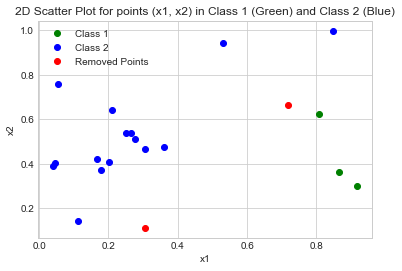

In [11]:
plot_2D_points(class_1_train_data[[1, 3, 4]], class_2_train_data, class_1_train_data[[0, 2]])

Suppose that we remove the two points near the true decision boundary $x_1 - x_2 = 0$ from Class 1, denoted by the red dots. In that case, we can infer that the Perceptron might have a decision boundary that is close towards the green region, say something like $2x_1 - 3x_2 = 0$. This decision boundary is not close to the true decision boundary of $x_1 - x_2 = 0$. Thus, Perceptron criterion classification will likely to change significantly given different training data.

## Problem 2 - Weight Initialization, Dead Neurons, Leaky ReLU

### Answer 2.1

Check that we are using `Tensorflow 2.3`, otherwise some functions like `tf.keras.initializers.HeNormal` are not available

In [12]:
!pip show tensorflow

Name: tensorflow
Version: 2.3.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: six, gast, h5py, keras-preprocessing, tensorboard, wrapt, wheel, opt-einsum, tensorflow-estimator, numpy, astunparse, termcolor, grpcio, google-pasta, protobuf, absl-py
Required-by: 


Codebase from https://github.com/Intoli/intoli-article-materials/tree/master/articles/neural-network-initialization

In [17]:
import pandas as pd

import seaborn as sns
from matplotlib import rcParamsDefault

import tensorflow.keras
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [18]:
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                  optimizer=tensorflow.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from tensorflow.keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts


class LossHistory(tensorflow.keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))


Divide the main routine from the original source code into some functions below, for reusability and readability

In [19]:
def generate_mnist_data():
    # Load and prepare MNIST dataset.
    n_train = 60000
    n_test = 10000

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    n_classes = len(np.unique(y_test))
    data_dim = 28 * 28

    x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
    x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
    x_train /= 255
    x_test /= 255

    y_train = tensorflow.keras.utils.to_categorical(y_train, n_classes)
    y_test = tensorflow.keras.utils.to_categorical(y_test, n_classes)

    return x_train, y_train, x_test, y_test, n_classes, data_dim

def train_model(params):
    activation_data = []
    
    if params['kernel_init'] == 'random_normal':
        print('Using Random Normal')
        kernel_init = initializers.RandomNormal(mean=0.0, stddev=params['stddev'], seed=params['seed'])
    elif params['kernel_init'] == 'glorot_normal':
        print('Using Glorot Normal')
        kernel_init = initializers.GlorotNormal(seed=params['seed'])
    elif params['kernel_init'] == 'he_normal':
        print('Using He Normal')
        kernel_init = initializers.HeNormal(seed=params['seed'])
    else:
        print('Invalid initializer')
        assert False

    model = create_mlp_model(
        params['n_hidden_layers'],
        params['dim_layer'],
        (params['data_dim'],),
        params['n_classes'],
        kernel_init,
        params['bias_init'],
        params['activation']
    )
    
    compile_model(model)
    
    output_elts = get_activations(model, x_test)
    
    n_layers = len(model.layers)
    
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                activation_data.append([i, stddev, out_i])
                
    return activation_data   

def plot_activations_random_normal(df, sigmas, activation):
    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
    fig = plt.figure(figsize=(15, 12))

    axes = grid_axes_it(len(sigmas), 1, fig=fig)

    for i, sig in enumerate(sigmas):
        ax = next(axes)
        ddf = df[df['Standard Deviation'] == sig]
        sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

        ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {:.2f})$ using {} activation function in hidden layers'.format(sig, activation), fontsize=13)

        ax.set_xlabel("Hidden Layer")

        if i == len(sigmas) // 2: 
            ax.set_ylabel("Neuron Activations")

        if i != len(sigmas) - 1:
            ax.set_xticklabels(())

    plt.tight_layout()
    plt.show()
    
def plot_activations_glorot_and_he_normal(df, init, activation):
    # Plot previously saved activations from the 5 hidden layers
    # using different initialization schemes.
    fig = plt.figure(figsize=(15, 12))

    axes = grid_axes_it(1, 1, fig=fig)
    ax = next(axes)
    
    sns.violinplot(x='Hidden Layer', y='Output', data=df, ax=ax, scale='count', inner=None)

    ax.set_title('Weights Drawn from {} Uniform using {} activation function in hidden layers'.format(init, activation), fontsize=13)

    ax.set_xlabel("Hidden Layer")
    ax.set_ylabel("Neuron Activations")
    ax.set_xticklabels(())

    plt.tight_layout()
    plt.show()


Vanishing Gradients Phenomenon using Random Normal Initialization for Tanh and Sigmoid Activation Function

Tanh Hidden Layer Neuron Activation Plots
-------------------
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal


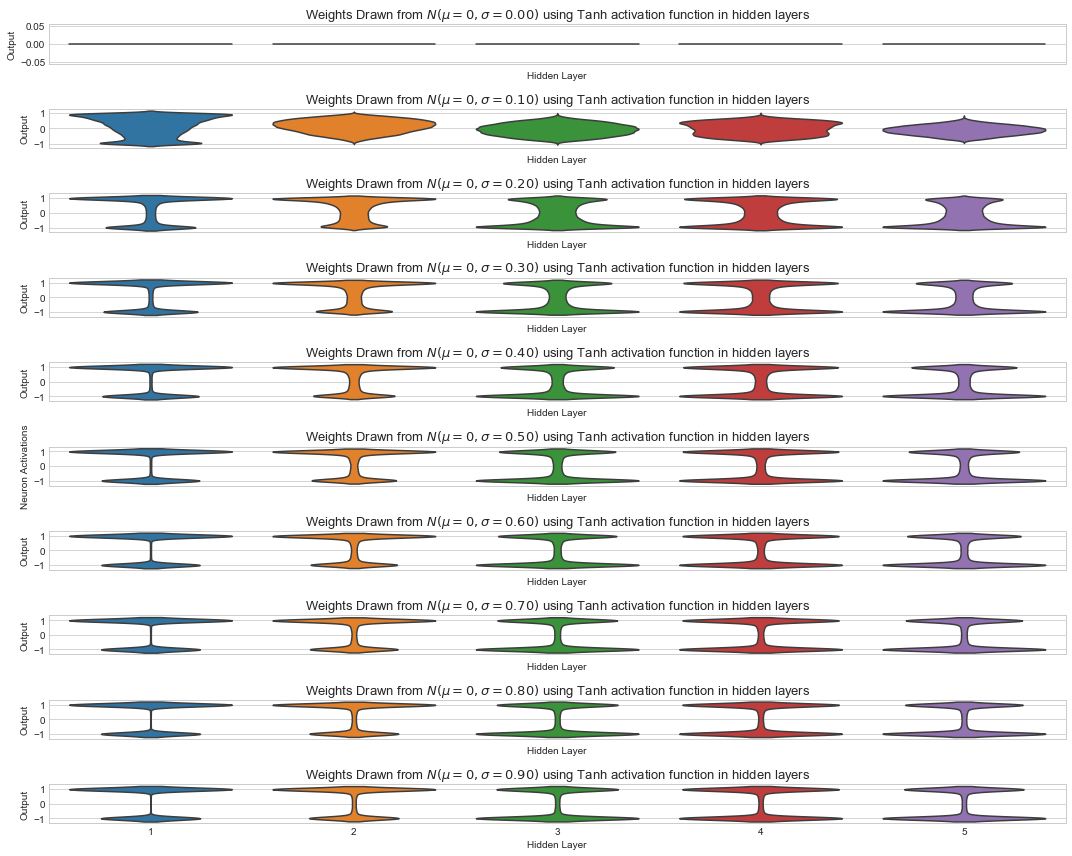

Sigmoid Hidden Layer Neuron Activation Plots
-------------------
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal
Using Random Normal


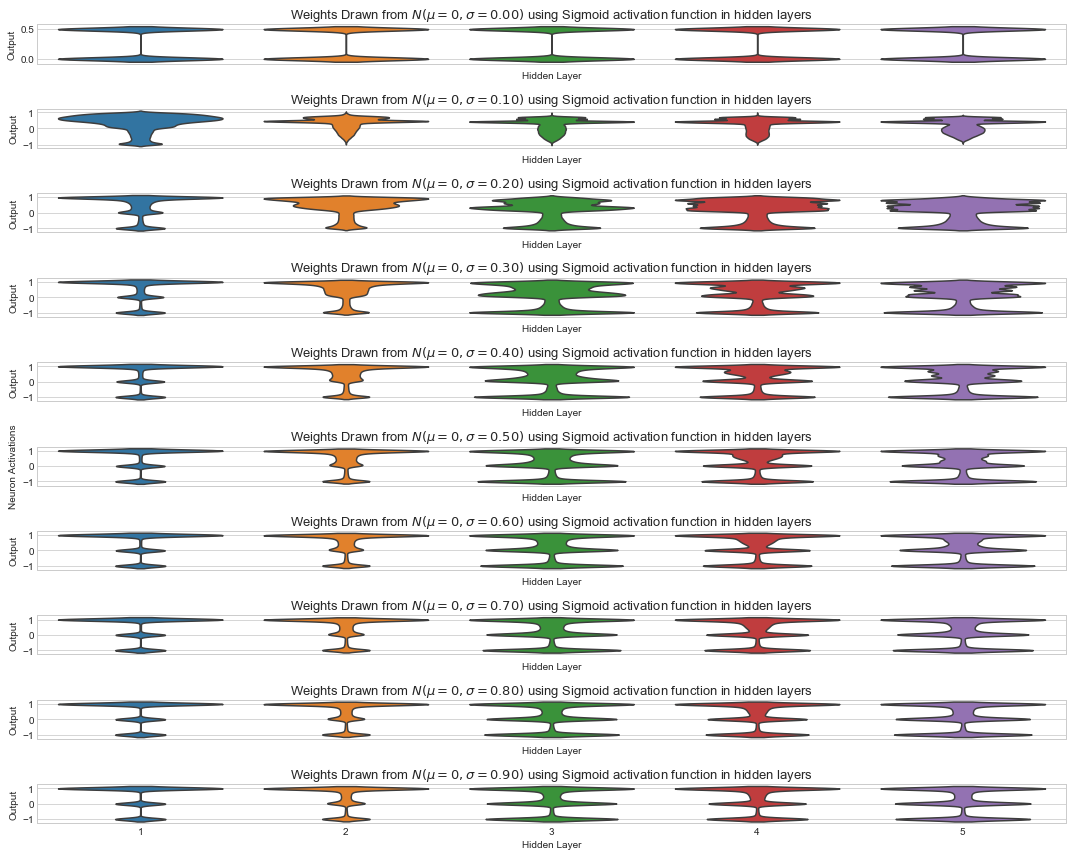

In [20]:
# Generate train and test data from MNIST
x_train, y_train, x_test, y_test, n_classes, data_dim = generate_mnist_data()

# MLP Params in relation to the dataset
params = {
    'n_hidden_layers': 5,
    'dim_layer': 100,
    'data_dim': data_dim,
    'n_classes': n_classes,
    'kernel_init': 'random_normal',
    'bias_init': 'zeros',
    'seed': 10
}

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
activation_data = []
activations = ['Tanh', 'Sigmoid']
sigmas = np.arange(0.0, 1.0, 0.1)

for activation in activations:
    print(activation + ' Hidden Layer Neuron Activation Plots')
    print('-------------------')
    
    params['activation'] = activation.lower()
    
    for stddev in sigmas:
        params['stddev'] = stddev
        
        for activation_datum in train_model(params):
            activation_data.append(activation_datum)

    df = pd.DataFrame(activation_data, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

    plot_activations_random_normal(df, sigmas, activation)

We can see that ...

Fixing Vanishing Gradients Phenomenon using Glorot Uniform Initialization for Tanh and Sigmoid Activation Function

Tanh Hidden Layer Neuron Activation Plots
-------------------
Using Glorot Normal


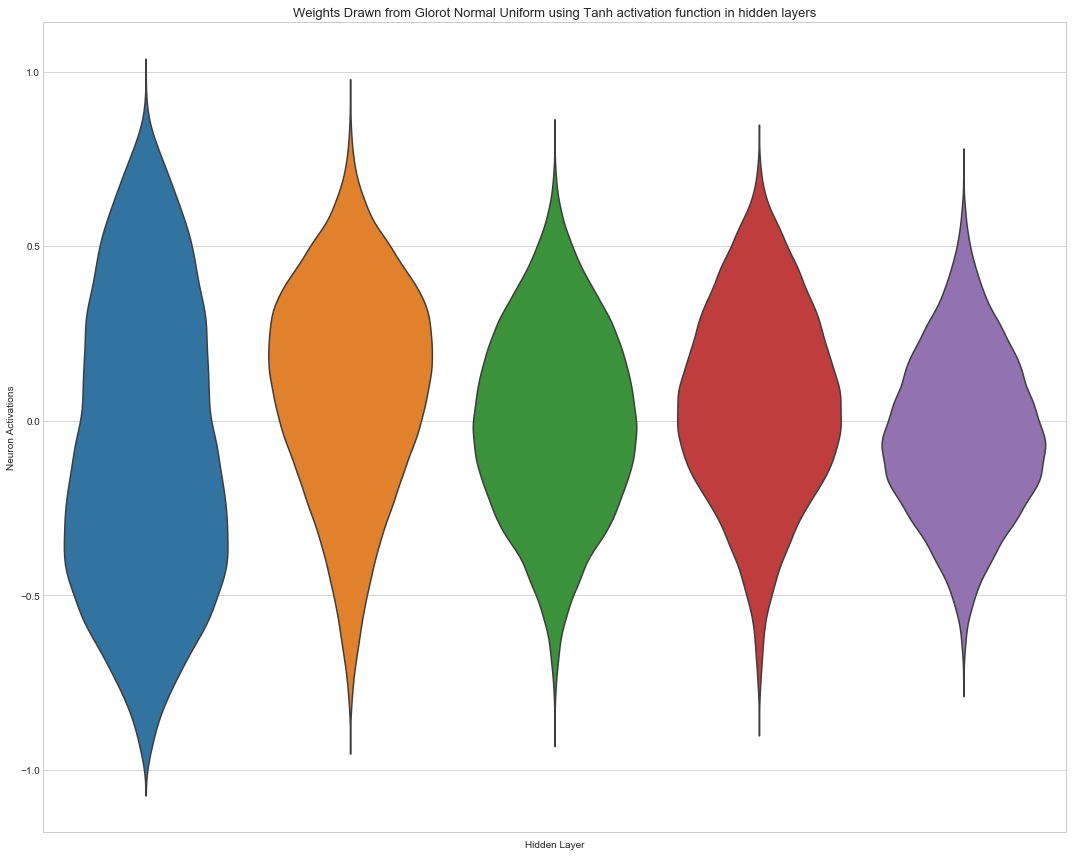

Sigmoid Hidden Layer Neuron Activation Plots
-------------------
Using Glorot Normal


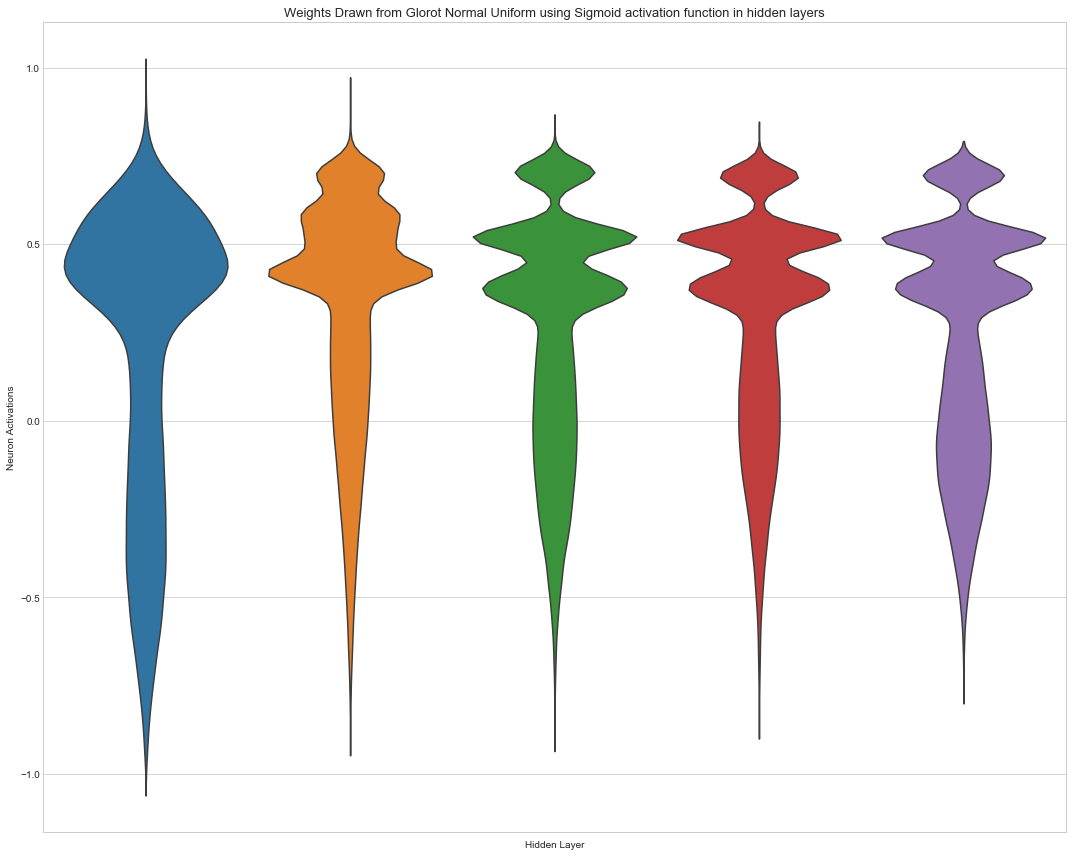

relu Hidden Layer Neuron Activation Plots
-------------------
Using Glorot Normal


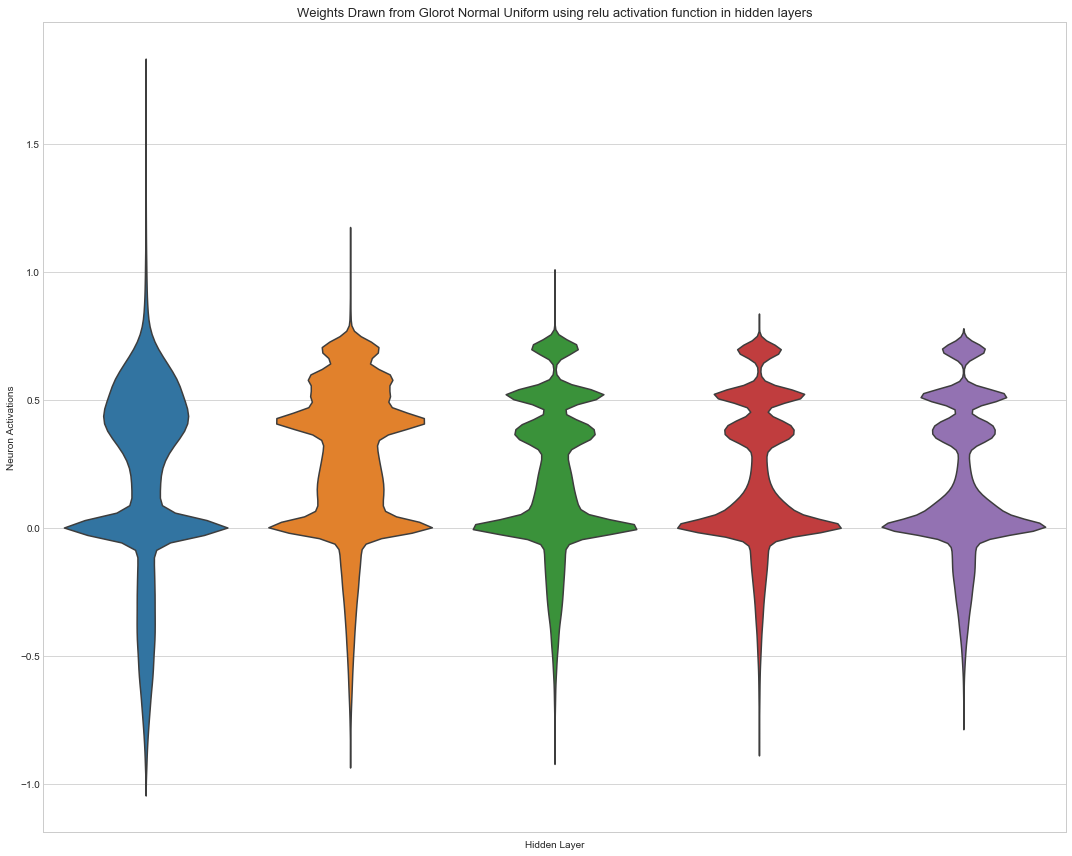

In [21]:
# Update 'kernel_init', i.e. weight initializer, in MLP Params
params['kernel_init'] = 'glorot_normal' 

# Empty activation data
activation_data = []

# Add ReLU activation function
activations.append('relu')

for activation in activations:
    print(activation + ' Hidden Layer Neuron Activation Plots')
    print('-------------------')
    
    params['activation'] = activation.lower()
        
    for activation_datum in train_model(params):
        activation_data.append(activation_datum)

    df = pd.DataFrame(activation_data, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
    df.drop(['Standard Deviation'], axis=1)

    plot_activations_glorot_and_he_normal(df, 'Glorot Normal', activation)

We can see that...

Finally, we're using He initializers with ReLU activation function in hidden layers

ReLU Hidden Layer Neuron Activation Plots
-------------------
Using He Normal


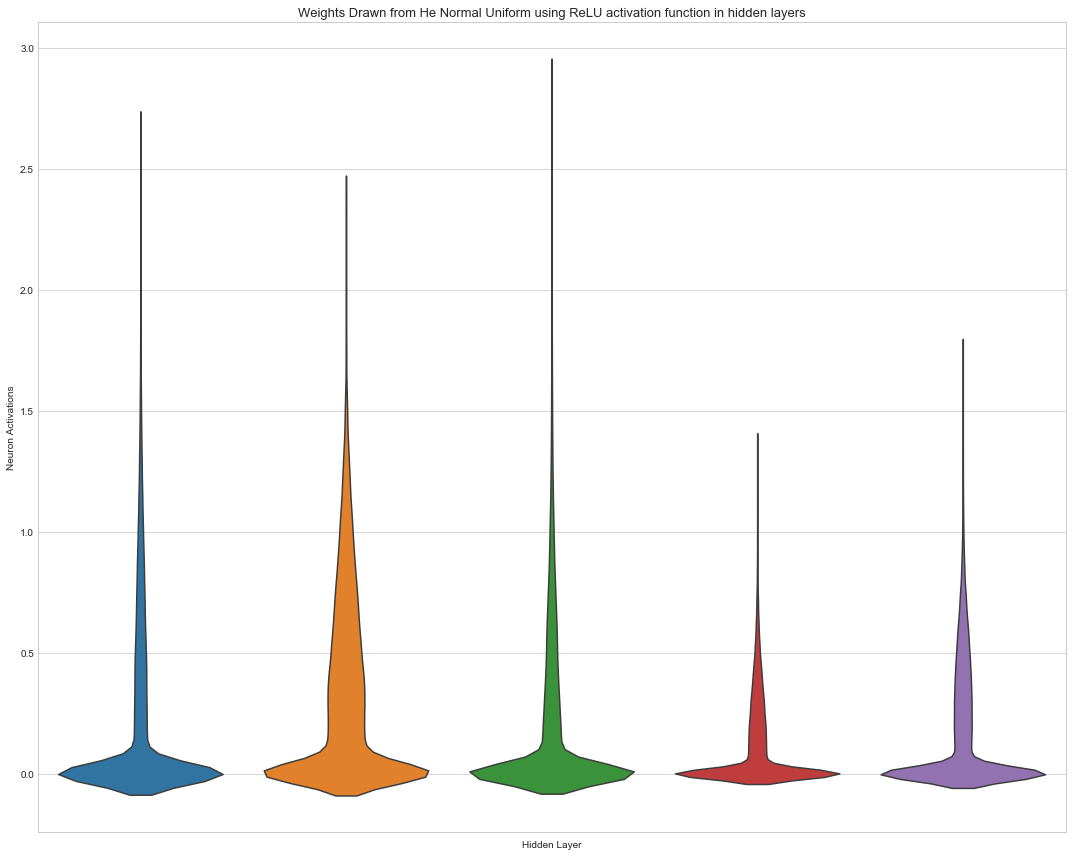

In [22]:
# Update 'kernel_init', i.e. weight initializer, in MLP Params
params['kernel_init'] = 'he_normal' 

# Empty activation data
activation_data = []

# Only use ReLU
activations = ['ReLU']

for activation in activations:
    print(activation + ' Hidden Layer Neuron Activation Plots')
    print('-------------------')
    
    params['activation'] = activation.lower()
        
    for activation_datum in train_model(params):
        activation_data.append(activation_datum)

    df = pd.DataFrame(activation_data, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
    df.drop(['Standard Deviation'], axis=1)

    plot_activations_glorot_and_he_normal(df, 'He Normal', activation)

### Answer 2.2

In [33]:
from tensorflow.keras.utils import to_categorical

In [32]:
# Configuration options
feature_vector_length = 784
num_classes = 10

# Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Reshape the data - MLPs do not understand such things as '2D'.
# Reshape to 28 x 28 pixels = 784 features
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

# Convert into greyscale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Convert target classes to categorical ones
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(350, input_shape=input_shape, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2)

# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


[1 0 1 ... 7 6 9]


### Answer 2.3

## Problem 3 - Batch Normalization, Dropout, MNIST

### Answer 3.1

### Answer 3.2

### Answer 3.3

### Answer 3.4

### Answer 3.5

## Problem 4 - Learning Rate, Batch Size, FashionMNIST

### Answer 4.1

### Answer 4.2

### Answer 4.3

### Answer 4.4

### Answer 4.5

### Answer 4.6

### Answer 4.7